# Text model training for the paper "A high-performance neuroprosthesis for speech decoding and avatar control"

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load packages
import numpy as np
import pandas as pd
import argparse
from os.path import join
import torchaudio
import torch
from torchaudio.models import decoder
from torchaudio.models.decoder import download_pretrained_files


print('torch version', torch.__version__)
print('torch audio version', torchaudio.__version__)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms


from data_loading_utilities.normalize import normalize
import copy
import wandb
import os

/server/path/torchaud/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version 1.12.0
torch audio version 0.12.0


In [3]:
# Load a GPU and modify this to be your directories!!!!
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = str(2)
curdir = './' # TODO: Change to your current directory
data_dir = './data' # TODO: Change to where the data is stored. 
device = 'cuda' # Set to cpu if you dont have a gpu avaiable! 

Wed Aug 23 06:33:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:3B:00.0 Off |                  N/A |
| 28%   34C    P2    35W / 250W |   3076MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN V      Off  | 00000000:5E:00.0 Off |                  N/A |
| 28%   

In [4]:
# Set up the experiment, can change the hyperparameters as you see fit or edit for your own models
parser = argparse.ArgumentParser()
parser.add_argument('--decimation', 
                   default=6, 
                   type=int, 
                   help='How much to downsample neural data')
parser.add_argument('--hidden_dim',
                    type=int,
                   default=256,
                   help="how many hid.units in model")
parser.add_argument('--lr', 
                    type=float,
                   default=1e-3,
                   help='learning rate')
parser.add_argument('--ks', 
                    type=int,
                   default=2,
                   help='ks of input conv')
parser.add_argument('--num_layers',
                   type=int, 
                   default=4,
                   help='number of layers')
parser.add_argument('--dropout', 
                   type=float, 
                   default=0.5, 
                   help='dropout amount')
parser.add_argument('--feat_stream', 
                   type=str, 
                   default='both',
                   help='which stream. both, hga, or raw')
parser.add_argument('--bs',
                   type=int, 
                   default=64, 
                   help='batch size')
parser.add_argument('--smooth',
                   type=int,
                   default=0)
parser.add_argument('--no_normalize', 
                   action='store_false',
                   help='If you add')
parser.add_argument('--LM_WEIGHT', 
                   help='how much the LM is weighted during beam search', 
                   type=float, 
                   default=3.23)
parser.add_argument('--WORD_SCORE', 
                   help='word insertion score for beam',
                    type=float,
                    default=-.26
                   )
parser.add_argument('--beam_width', 
                   help='beam size to use',
                   type=int,
                   default=100)
parser.add_argument('--checkpoint_dir',
                   help='where 2 load model',
                   type=str,
                   default=None)
parser.add_argument('--feedforward', 
                   help='no bidirectional',
                   action='store_true')
parser.add_argument('--pretrained',
                   help='pretrained model',
                   type=str,
                   default=None)
parser.add_argument('--train_amt',
                   help='amt of train data',
                   type=float, 
                    default=1.0)
parser.add_argument('--samples_to_trim',
                   help='num samps back to go',
                   default=0, 
                   type=int)
parser.add_argument('--ndense',
                   help='transfer dense',
                   default=40,
                   type=int)
parser.add_argument('--transfer_audio', 
                   help='true if transfer audio. then switch conv', 
                   action='store_true')

parser.add_argument('--num_50', 
                   help='how many of the 50 phrase datapoints to use, so to not over fit', 
                   type=int,
                   default=500)
parser.add_argument('--num_500', 
                   help='how much 500 phrase data to use',
                   type=int,
                   default=None)
parser.add_argument('--eval_set', 
                   help='which eval set to use, for CV', 
                   type=int,
                   default=None)

parser.add_argument('--model_type', 
                    help='which model to use',
                   type=str,
                   default='cnnrnn')

#### NEW ARGS FOR CRDNN
parser.add_argument('--KS2', 
                   help='kernel size for second conv',
                    type=int,
                   default=2)
parser.add_argument('--stride1',
                   help='stride, conv1',
                   type=int,
                   default=1)
parser.add_argument('--stride2', 
                   help='stride, conv2',
                   type=int,
                   default=2)

parser.add_argument('--jitter_amt', 
                    help='how much 2 jit',
                    type=float, 
                    default=0.5)

parser.add_argument('--chan_noise', 
                    help='how much noise', 
                    type=float,
                    default=0.04)

parser.add_argument('--blackout_prob', 
                    help='odds of blackout for data augmentation', 
                    type=float, 
                    default=0.05)
parser.add_argument('--weight_decay', 
                    help='weight decay to apply to weights', 
                    type=float,
                    default=None)

parser.add_argument('--printall', 
                   help='print every pred during evaluation, useful to see all predictions. ',
                   action='store_true')

parser.add_argument('--word_ct_weight',
                   help='how much to weight the word count loss',
                   type=float, 
                   default=0.0)

parser.add_argument('--clipamt',
                   help='how much to clip gradient',
                   type=float,
                   default=1.0)

parser.add_argument('--winstart', 
                   help='how much time before go-cue to use during model training',
                   type=float, 
                   default=0.0)
parser.add_argument('--winend',
                   help='how much time after go cue to use during model training/eval',
                   type=float,
                   default=7.5)

parser.add_argument('--normalization_strategy', 
                    help='how to normalize the data',
                    type=str, 
                    default='typical')
parser.add_argument('--area_to_ablate',
                    help='which area to hold out',
                    default = None)
parser.add_argument('--low_density',
                    help='downsample the grid',
                    action='store_true')

_StoreTrueAction(option_strings=['--low_density'], dest='low_density', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='downsample the grid', metavar=None)

In [5]:
args = vars(parser.parse_args('--jitter_amt 1 --chan_noise .0 --weight_decay 1e-05 --LM_WEIGHT 4 --train_amt 1 --hidden_dim 500 --ks 4 --dropout 0.4 --num_layers 3 --eval_set 1 --decimation 6 --word_ct_weight 0.0 --clipamt .0001 --winstart -0.5 --normalization_strategy norm_times'.split()))
wandb.init(project='pub_code', 
          config=args)

wandb: Currently logged in as: slm. Use `wandb login --relogin` to force relogin


<<<<<<< local <modified: text/html; unchanged: text/plain>


>>>>>>> remote <modified: text/html; unchanged: text/plain>


In [6]:
# Lets load in the labels first and take a look. Its saved as a dataframe. 
# key values are the ph_label  - phone label
# and txt_label, the text
labels = pd.read_hdf(join(data_dir, 'training_labels.h5'))
labels_te = pd.read_hdf(join(data_dir, 'realtime_test_labels.h5'))

# Check no test sents in training data :D 
for l in labels_te['txt_label'].values: 
    assert not l in labels['txt_label'].values
    
labels = pd.concat((labels, labels_te), ignore_index=True)

In [7]:
# Next lets load in the neural data. 
import os
if args['decimation'] ==6:
    """
    Here we're loading the predecimated data
    """
    X = np.load(os.path.join(data_dir, f"train_data.npy"))
    X_te = np.load(os.path.join(data_dir, f"realtime_test_data.npy"))

X = np.concatenate((X, X_te), axis=0)
print('train samples', X.shape[0] - X_te.shape[0]) 
print('test samples', X_te.shape[0])

# Extract the words
all_labs = set(labels['txt_label'].values)
all_words = []
for a in all_labs: 
    all_words.extend(a.split(' '))

train samples 9506
test samples 249


In [8]:
from data_loading_utilities.normalize import * # Laod up the data normalization strategies

In [9]:
# Lets normalize the data, can use a variety of options. 
# We just noramlize across time so that the 2 norm across time is equal to 1. 
if args['normalization_strategy'] == 'typical':
    X[:, :, :X.shape[-1]//2] = normalize(X[:, :, :X.shape[-1]//2])
    X[:, :, X.shape[-1]//2:] = normalize(X[:, :, X.shape[-1]//2:])
elif args['normalization_strategy'] == 'norm_all_at_once':
    X= normalize(X)
elif args['normalization_strategy'] == 'norm_times':
    X = normalize(X, axis=1)
elif args['normalization_strategy'] == 'zero_to_one':
    X = minmax_scaling(X)
elif args['normalization_strategy'] == 'rezscore':
    X = rezscore(X)
elif args['normalization_strategy'] == 'none': 
    print('no normalization.')
elif args['normalization_strategy'] == 'pertrial_minmax':
    X = pertrial_minmax(X)

    
# Can edit this to be just one feature stream if you'd like to see effect of using hga vs hga + raw.
if args['feat_stream'] == 'hga':
    X = X[:, :, :X.shape[-1]//2]
elif args['feat_stream'] == 'raw':
    X = X[:, :, X.shape[-1]//2:]
print('final X shape', X.shape)

final X shape (9755, 300, 506)


### Now, we need to prepare labels for the ctc_decoding and decoder trainings

In [10]:
import sys
sys.path.append('./')

In [11]:
print(sys.path)

['/server/path/repos/pub_code/text', '/server/path/torchaud/lib/python39.zip', '/server/path/torchaud/lib/python3.9', '/server/path/torchaud/lib/python3.9/lib-dynload', '', '/server/path/torchaud/lib/python3.9/site-packages', '/server/path/repos/gimdecode', '/server/path/repos/realtime', './']


In [12]:
from train.ctc_decoding import GreedyCTCDecoder

In [13]:
# we will rely on the torchaudio ctc_decoder module, which you can read more about here: https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html
from torchaudio.models.decoder import ctc_decoder
from torchaudio.functional import edit_distance

In [14]:
from data_loading_utilities.clean_labels import clean_labels
# Clean up the labels and remove stress marking from phones. 
labels, all_ph = clean_labels(labels)
phone_enc  = {v:k for k,v in enumerate(sorted([a for a in list(set(all_ph)) if not a == '|']))}


In [15]:
# Now lets set up a lexicon to map from each word to any valid pronounciation. 
from collections import defaultdict
lex = {}

for k,v in zip(labels['txt_label'], labels['ph_label']):
    if not '|' in v:
        lex[k] = (' '.join(v) + ' |')
    else: 
        v  = '_'.join(v)
        v = v.split('|')
        for kk, vv in zip(k.split(' '), v):
            vv = vv.replace('_', ' ').strip() + ' |'
            if not kk == '':
                lex[kk] = vv

In [16]:
# Write the lexicon to a text file for the ctc decoder, and prepare it. 
strings = []
for k, v in lex.items():
    string = k + ' ' + str(v)
    strings.append(string)
    
strings =  [s for s in strings if len(s) > 3]

with open(join(curdir, "for_ctc/lexicon_phrases_1k.txt"), "w") as f:
    f.writelines([s+ '\n' for s in strings])

print('example lexicon items')
for s in strings[:5]:
    print(s)
print('vocabulary size:', len(strings))

example lexicon items
i AY |
feel F IY L |
like L AY K |
driving D R AY V IH NG |
are AA R |
vocabulary size: 1024


In [17]:
# Prepare the tokens for the ctc decoder. 
tokens = ['-', '|'] + list(phone_enc.keys())
with open(join(curdir, 'for_ctc/tokens_phrases_1k.txt'), 'w') as f:
    f.writelines([t + '\n' for t in tokens])
enc_final = {v:k for k,v in enumerate(tokens)} # Use to map phone to y labels

In [18]:
beam_search_decoder= ctc_decoder(
    lexicon = join(curdir, 'for_ctc/lexicon_phrases_1k.txt'),
    tokens = join(curdir, 'for_ctc/tokens_phrases_1k.txt'),
    lm = join(curdir, 'custom_lms/full_corpus_lm_3_abs_slm.binary'),
    nbest=3,
    beam_size=args['beam_width'],
    lm_weight=args['LM_WEIGHT'],
    word_score=args['WORD_SCORE'],
    sil_token = '|', 
    unk_word = '<unk>',
)

greedy_decoder = GreedyCTCDecoder(tokens)
greedy = GreedyCTCDecoder(labels=list(enc_final.keys()))

# Prepare neural and target data for CTC loss
y_final = []
for t, targ in zip(labels['txt_label'], labels['ph_label']):
    cur_y = []
    cur_y.append(enc_final['|'])
    for ph in targ:
        cur_y.append(enc_final[ph])
    cur_y.append(enc_final['|'])
    y_final.append(cur_y)

# Pad with -1
y_final_ = -1*np.ones((len(y_final), np.max([len(y) for y in y_final])))

# Store the lengths
targ_lengths =[]
for k, y in enumerate(y_final):
    y_final_[k, :len(y)] = np.array(y)
    targ_lengths.append(len(y))
targ_lengths = np.array(targ_lengths)
Y = y_final_

lens = [(l//args['decimation']) for l in labels['length']] # Adjust lengths based on decimation. 
# Finalize the lengths. 
outlens = targ_lengths
lens = np.array(lens)
lens = lens - args['samples_to_trim']

# Adjust lenghts to be correct. 
lens = [min(l, X.shape[1]) for l in lens]
lens = np.array(lens)

token lm False


In [19]:
X.shape[0]-249

9506

In [20]:
# Set up the training, val, and test sets. 
trainsets = []
inds = np.arange(len(X))

# Day of the data we used for testing
test_day_inds = copy.deepcopy(inds[-249:])

In [21]:
print(X.shape)

(9755, 300, 506)


In [22]:
# Ignore these
off_limits = list(test_day_inds)

test_inds_eligible= inds
np.random.seed(1337)
np.random.shuffle(test_inds_eligible)


# Use 5% of the data for val, 5% test, 90% to train.
# The final test day data isn't touched yet. 
for k in range(10): 
    te_inds = test_inds_eligible[k*(len(inds)//20): (k+1)*(len(inds)//20)]
    te_inds = [i for i in te_inds if not i in off_limits] # for test set during training. 
    val_inds = test_inds_eligible[(k+2)*(len(inds)//20):(k+3)*(len(inds)//20)]
    val_inds = [i for i in val_inds if not i in te_inds and not i in off_limits]
    tr_inds = [i for i in inds if not i in list(te_inds) + list(val_inds)]    
    tr_inds = [i for i in tr_inds if not i in off_limits]
    trainsets.append((tr_inds, val_inds, te_inds))

# Get out the ground truth text. 
gt_text = labels['txt_label'].values
tokens

# Choose which fold to evaluate. 
if not args['eval_set'] is None: 
    eval_set = args['eval_set']
    trainsets = trainsets[eval_set:eval_set+1]
    

from data_loading_utilities.torch_ctc_loaders import CTCDataset, Jitter, Blackout, AdditiveNoise, LevelChannelNoise, ScaleAugment

In [23]:
# Now lets set up dataloaders and augmentations.
b1args = {'winstart': 0, 'winend': 7.5,  'additive_noise_level': 0.0027354917297051813, 
        'scale_augment_low': 0.9551356218945801, 'scale_augment_high': 1.0713824626558794, 
        'blackout_len': 0.30682868940865543, 'blackout_prob': 0.04787032280216536,
        'random_channel_noise_sigma': 0.028305685438945617
        }
#
train_jitter = Jitter((-1, 8), (args['winstart'], args['winend']), jitter_amt=args['jitter_amt'], decimation=args['decimation'])
test_jitter = Jitter((-1,8), (args['winstart'], args['winend']), jitter_amt=0.0, decimation=args['decimation'])
train_jitter.winsize, test_jitter.winsize

lens[:] = train_jitter.winsize

blackout = Blackout(b1args['blackout_len'], args['blackout_prob'])
noise = AdditiveNoise(b1args['additive_noise_level'])
chan_noise = LevelChannelNoise(args['chan_noise'])
scale = ScaleAugment(b1args['scale_augment_low'], b1args['scale_augment_high'])

composed = transforms.Compose([
    train_jitter,  blackout , noise, chan_noise, scale
])

test_augs = transforms.Compose([
    test_jitter
])
# test_augs
from train.ctc_aux_loss_trainer import train_loop
from models.cnn_rnn_w_aux import AUXCnnRnnClassifier
from data_loading_utilities.torch_ctc_loaders import CTCDataset_Wordct


# The word targets actually are not used (weight set to zero), but they are here in case you'd find them useful!
word_targets = []
for l in labels['txt_label'].values:
    word_targets.append(len(l.split(' ')))

n_wordtarg = np.max(word_targets)

scale 0.9551356218945801 1.0713824626558794


# What to expect from training: 

Model will run for around 100 epochs. There is some variability in performance based on initializations. We interrupted training here for the sake of time 

We are using a 3-gram LM and small beam search here - as a result accuracy is LOWER during training, than when you test on the final set

The WER should end around 35-42% prior to testing on the realtime blocks

Using the 5-gram LM and larger beam search will help get the WER much lower when we evaluate on the realtime blocks, below 30% without the blocking.

Note: The saved output here was interrupted for the sake of time

In [24]:
# Split data into train/val/test sets. 
for train, val, test in trainsets:
    # Train test split, plus load into dataset
    # Limit data to be the same for the k oflds
    val = val[:450]
    test = test[:450]
    print('Sample sizes tr/val/test', len(train), len(val), len(test))
    train_amt = int(len(train)*args['train_amt'])
    print('num samples', train_amt)
    wandb.log({'num_samples':train_amt})
    train = train[:train_amt]
    lens = np.array(list(lens))

    word_targets = np.array(word_targets)

    X_tr, X_val, X_te = X[train], X[val], X[test]
    Y_tr, Y_val, Y_te = Y[train], Y[val], Y[test]
    print('Xtr', X_tr.shape, 'Y_tr', Y_tr.shape)
    lens_tr, lens_val, lens_te = lens[train], lens[val], lens[test]
    inds_tr, inds_val, inds_te = np.array(train), np.array(val), np.array(test) # for loading text labels.
    outlens_tr, outlens_val, outlens_te = outlens[train], outlens[val], outlens[test]
    word_targs_tr, word_targs_val, word_targs_te = word_targets[train], word_targets[val], word_targets[test]
    
    train_dset = CTCDataset_Wordct(X_tr, Y_tr, lens_tr, outlens_tr, inds_tr, word_targs_tr, transform=composed)
    val_dset = CTCDataset_Wordct(X_val, Y_val, lens_val, outlens_val, inds_val, word_targs_val, transform=test_augs)
    test_dset = CTCDataset_Wordct(X_te, Y_te, lens_te, outlens_te, inds_te, word_targs_te, transform=test_augs)
    
    # TODO: Add transforms from torchaudio.transforms
    train_loader = DataLoader(train_dset, batch_size=args['bs'], shuffle=True) 
    test_loader = DataLoader(test_dset, batch_size=min(X_te.shape[0], args['bs']), shuffle=False)
    val_loader = DataLoader(val_dset, batch_size=min(args['bs'], X_val.shape[0]), shuffle=False)
    
    tdi = test_day_inds
    print(X.shape)
    X_final, Y_final, lens_final, outlens_final = X[tdi], Y[tdi], lens[tdi], outlens[tdi]
    inds_final = np.array(tdi)
    word_targs_final = word_targets[tdi]
    final_dset = CTCDataset_Wordct(X_final, Y_final, lens_final, outlens_final, inds_final, word_targs_final, transform=test_augs)
    
    break


# Now we load in the final realtime test blocks. 
final_loader = DataLoader(final_dset, batch_size=args['bs'], shuffle=False)
    
# Initialize the model. 
device='cuda'
if not args['feedforward']:
    if not args['pretrained'] is None: 
        n_targ = args['ndense']
    else: 
        n_targ=len((enc_final))


    if args['model_type'] == 'cnnrnn':
        model = AUXCnnRnnClassifier(rnn_dim=args['hidden_dim'], KS=args['ks'], 
                                         num_layers=args['num_layers'],
                                         dropout=args['dropout'], n_targ=n_targ,
                                  bidirectional=True, in_channels=X_tr.shape[-1], nword_targ=n_wordtarg+1)

wandb.log({
    'n_targ':len((enc_final)),
    'in_channels':X_tr.shape[-1]
})

if args['weight_decay'] is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
else: 
    optimizer = torch.optim.AdamW(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
model = model.to(device)

# Now we run the train loop. It will train up the model. 
# Every three epochs, it will check in on the model perfomrance and see how it's doing 
# Training takes about 1.5-2 hours on an NVIDIA TITAN V GPU
model =train_loop(model, train_loader,
                val_loader, 
                  optimizer,
                device, gt_text, greedy, beam_search_decoder, tokens, start_eval=0, 
                 wandb_log=True, checkpoint_dir=args['checkpoint_dir'], printall=args['printall'],
                 wordloss_weight=args['word_ct_weight'], clipamt =args['clipamt'], 
                 max_epochs=1000)

# Currently we only use one fold for model dev. 

from train.eval_script import test_ensemble

Sample sizes tr/val/test 8555 450 450
num samples 8555
Xtr (8555, 300, 506) Y_tr (8555, 46)
(9755, 300, 506)


/server/path/repos/pub_code/text/models/cnn_rnn_w_aux.py:43: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  lens = lens//self.ks


net wer 1.0
net cer 1.0
greedy per 0.7730677566431435
beam per 0.7870946146226481
gt are you kidding me
t  wer: 1.00 cer: 1.00
gt what if i did
t  wer: 1.00 cer: 1.00
gt for the time being
t  wer: 1.00 cer: 1.00
gt that would explain it
t  wer: 1.00 cer: 1.00
gt get out of there
t  wer: 1.00 cer: 1.00
gt i have a wonderful new play
t  wer: 1.00 cer: 1.00
gt then how come it worked loose
t  wer: 1.00 cer: 1.00
gt we all have problems
t  wer: 1.00 cer: 1.00
gt would you know the room
t  wer: 1.00 cer: 1.00
gt no need to apologize
t  wer: 1.00 cer: 1.00
gt that i would find the one
t  wer: 1.00 cer: 1.00
epoch 0 tr loss: 0.050 te_loss: 0.047
epoch 1 tr loss: 0.036 te_loss: 0.034
epoch 2 tr loss: 0.029 te_loss: 0.031
net wer 0.7996031746031754
net cer 0.6714796038535238
greedy per 0.4758657507300975
beam per 0.5709653929805514
gt feels good to be back
t will you be wer: 0.80 cer: 0.71
gt you go to school together
t you go to you wer: 0.40 cer: 0.56
gt i wish we could hear them
t i know wer


KeyboardInterrupt



# Now lets run on the realtime test data

In [25]:
# Step 1: Define a new beam size, we found taht using a larger beam size
# is quite helpful here and will lower the word error rate. 
beam_search_decoder_final = ctc_decoder(
    lexicon = join(curdir, 'for_ctc/lexicon_phrases_1k.txt'),
    tokens = join(curdir, 'for_ctc/tokens_phrases_1k.txt'),
    lm = join(curdir, 'custom_lms/full_corpus_lm_5_abs_slm.binary'),
    nbest=3,
    beam_size=3000,
    lm_weight=4.5,
    word_score=args['WORD_SCORE'],
    sil_token = '|', 
    unk_word = '<unk>')

token lm False


In [68]:
# Step 2: Evaluate on totally UNSEEN sentences
# We use the early stopping here as well
# The averaged WER does not take into account the sentence lengths so will differ from reported wer. 
from train.eval_script import test_ensemble
from train.sim_early_stop import test_ensemble_wpm
# Now we load in the final realtime test blocks. 
# We need to set the batch size to be 1 to get wpms
final_loader = DataLoader(final_dset, batch_size=1, shuffle=False)
realtime_test_results = test_ensemble_wpm(model, final_loader, greedy, beam_search_decoder_final, gt_text, tokens, wandb_name = 'rt_', realtime_eval=True)

/userdata/smetzger/repos/pub_code/text/models/cnn_rnn_w_aux.py:43: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  lens = lens//self.ks


net wer 0.28365366226812017
net cer 0.21281817063458622
greedy per 0.2853330700034549
beam per 0.1941643652813536
gt i thought everything was working out fine
t i thought it was make of mine wer: 0.57 cer: 0.44
gt come here i want to show you something
t have i want to say something wer: 0.50 cer: 0.34
gt what is it all about
t what is she ask about wer: 0.40 cer: 0.25
gt just look at all those people
t she look at all those people wer: 0.17 cer: 0.14
gt what did you do tonight
t what do you do tonight wer: 0.20 cer: 0.09
gt you were looking for us
t you were looking for us wer: 0.00 cer: 0.00
gt you got no idea what they were after
t you got no idea what they were after wer: 0.00 cer: 0.00
gt what kind of man are you
t what kind of man are you wer: 0.00 cer: 0.00
gt how did they find out
t how did they find out wer: 0.00 cer: 0.00
gt why would he pick this one
t why would he pick this one wer: 0.00 cer: 0.00
gt no one will believe us
t no one will believe us wer: 0.00 cer: 0.00


In [69]:
# The results should be very close to what we got in realtime.
wers = realtime_test_results[5]

# Can see the ground truth
gts = realtime_test_results[8]

# Can check out the decoded text!
decodes = realtime_test_results[9]

# WPMS
wpms = realtime_test_results[-1]

In [70]:
from torchaudio.functional import edit_distance
# Showing the wer calculation is legit!
assert edit_distance(decodes[0].split(), gts[0].split())/len(gts[0].split()) == wers[0]

In [71]:
# apply the pseudoblocking
def parceled_metric(vals, lengths=None, metric=np.mean, parcelation=10):
    # This function will do the pseudoblocking!
    dist = []
    cur_list = []
    cur_lengths = []
    if lengths is None: 
        lengths = np.ones((len(vals)))
    for k, x in enumerate(vals):
        cur_list.append(x)
        if pd.isna(x): 
            cur_lengths.append(np.nan)
        else: 
            cur_lengths.append(lengths[k])
        if (k+1)%parcelation == 0: 
            num = np.nansum(np.array(cur_list)*np.array(cur_lengths))
            dist.append(num/np.nansum(np.array(cur_lengths)))
            cur_list = []
            cur_lengths = []
    if len(cur_list) > parcelation/2: 
        dist.append(np.nansum(np.array(cur_list)*np.array(cur_lengths))/np.nansum(np.array(cur_lengths)))
    return np.array(dist)

In [72]:
pseudoblocked_results = parceled_metric(wers, lengths=np.array([len(txt.split()) for txt in gts]), metric=np.mean)

In [73]:
print(f'Median WER across pseudoblocks {np.median(pseudoblocked_results):.3f}')

Median WER across pseudoblocks 0.255


In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7fe8e61ebbe0>], [Text(0, 0, 'Decoded text')])

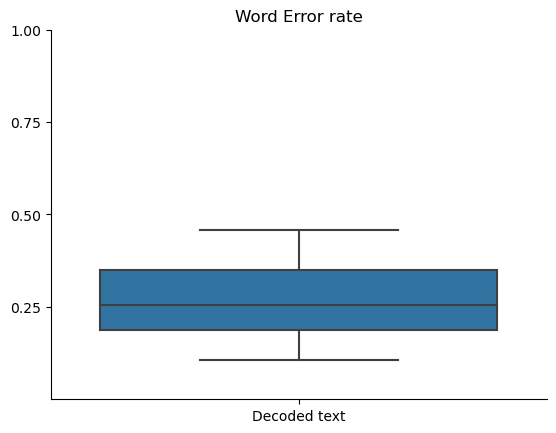

In [75]:
sns.boxplot(pseudoblocked_results)
plt.ylim(0, 1)
plt.yticks([0.25, 0.5, 0.75, 1.0])
plt.title('Word Error rate')
sns.despine()
plt.xticks([0], ['Decoded text'])

In [78]:
pseudoblocked_results = parceled_metric(wpms, lengths=None, metric=np.mean)
print("This run's median WPM %.2f" %np.median(pseudoblocked_results))

This run's median WPM 76.31


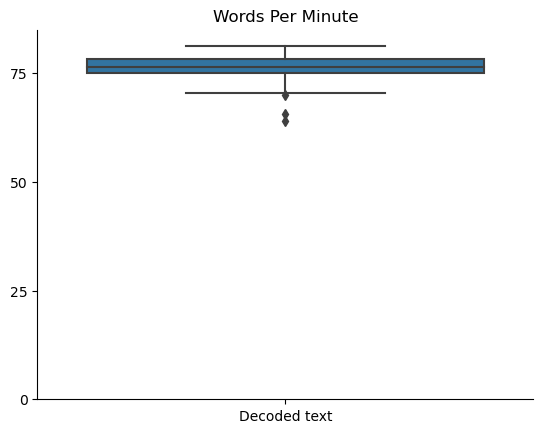

In [79]:
sns.boxplot(pseudoblocked_results)
plt.title('Words Per Minute')
plt.ylim(0, 85)
plt.yticks([0, 25, 50, 75])
sns.despine()
plt.xticks([0], ['Decoded text'])
plt.show()